<span style="font-family:Papyrus; font-size:3em;">Homework 1</span>

<span style="font-family:Papyrus; font-size:2em;">Design of Experiments for Parameter Interactions</span>

# Problem

This homework is an elaboration of the analysis of lecture 6 on computational experiments using a two factor at a time design.

1. (6 pt) Revise the codes from lecture 6 (in common>util_doe6.py) to cacluate the interaction terms $\gamma$
in the model $y = \alpha_{1,i_1} + \alpha_{2, i_2} + \gamma_{1, 2, i_1, i_2}$.
That is, calculate $y - \alpha_{1,i_1} + \alpha_{2, i_2}$, where $y$ is calculated from
``runExperimentTwoParameters`` in lecture 6 and the $\alpha$ are calculated using
``runExperiment`` from lecture 5.
(Don't forget to include 1 or more tests for the new function.)

1. (6 pt) Plot interactions for Glucose for the first 5 parameters: J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k
for frequency and amplitude.
   Comment on whether the responses are *over* or *under* estimated if the response $y$ is
   estimated using $y = \alpha_{1,i_1} + \alpha_{2, i_2}$.

1. (3 pt) What additional analyses should be done to understanding parameter interactions in this model?

# Programming Preliminaries
This section provides the setup to run your python codes.

In [1]:
IS_COLAB = False

In [2]:
# Code installs. Only needed once.
if IS_COLAB:
    !pip install matplotlib
    !pip install numpy
    !pip install pandas
    !pip install scipy
    !pip install tellurium
    !pip install seaborn

In [3]:
# Constants for standalone notebook
if not IS_COLAB:
    DIR = "/home/ubuntu/advancing-biomedical-models/common"  # Insert your local directory path
else:
    from google.colab import drive
    drive.mount('/content/drive')
    DIR = "/content/drive/MyDrive/Modeling_Class/Winter 2021/common"
import sys
sys.path.insert(0, DIR)

In [4]:
import wolf_model as wm
import util_doe1  # Various functions from lecture 5
import util_doe2  # Various functions from lecture 6

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import fftpack
import tellurium as te
import seaborn as sns

# Calculate interaction terms ($\gamma$)
This section contains revised and/or new functions that calculate the interaction terms and plot the results.
You can create this function by modifying ``runExperimentsTwoParameters`` used in lecture 6.
You should proceed with:
1. Create an internal function ``makeInteractionSer`` with parameters ``percent1`` and `percent2``. It returns
the response ``Series`` when the parameters have the levels specified by these levels.
1. Use ``makeInteractionSer`` to calculate the following within the internal function ``calcLevelResponseDF``:
   1. ``only1Ser``: percent1 is the value passed to ``calcLevelResponseDF``, ``percent2`` is 0.
   1. ``only2Ser``: percent2 is the value passed to ``calcLevelResponseDF``, ``percent1`` is 0.
   1. ``bothSer``: uses the values passed to ``calcLevelResponseDF``
   1. Calculate the interaction term $\gamma$.

In [5]:
def runExperimentsTwoParametersInteractionResponse(parameter1, parameter2, percent1s, percent2s, isRelative=True):
    """
    Runs experiments for changes in multipleparameters of the model at different percent changes 
    in the parameter value (levels). Responses are the interaction terms gamma.
    
    Parameter
    ---------
    parameter1: str
    parameter2: str
    percent1s: list-int
    percent2s: list-int
    isRelative: bool
        True: values are percent changes relative to baseline
        False: absolute value
        
    Returns
    -------
    frequencyDF: DataFrame, amplitude: DataFrame
       index: tuple of percent changes in parameter values
       columns: molecule
       value: interaction term gamma
       index.name: string of tuple (rowParameter, columnParameter)
    """
    INDEX1 = "index1"
    INDEX2 = "index2"
    # Calculate the baseline values
    baseFrequencySer, baseAmplitudeSer = util_doe1.runExperiment({})
    #
    def calcResponseSer(ser, isFrequency=True):
        """
        Calculates the relative response.
        
        Parameters
        ----------
        ser: pd.Series
            index: molecule
            value: absolute respoinse
        isFrequency: bool
            if True, frequency response; else, amplitude response
            
        Returns
        -------
        pd.Series
        """
        if not isRelative:
            return ser
        if isFrequency:
            baseSer = baseFrequencySer
        else:
            baseSer = baseAmplitudeSer
        resultSer = 100*(ser - baseSer)/baseSer
        return resultSer
    #
    def makeInteractionSer(percent1, percent2, isFrequency):
        """
        Calculates the response for the percent changes
        """
        parameterDct = {parameter1: percent1, parameter2: percent2}
        frequencySer, amplitudeSer = util_doe1.runExperiment(parameterDct)
        if isFrequency:
            ser = frequencySer
        else:
            ser = amplitudeSer
        adjSer = calcResponseSer(ser, isFrequency=isFrequency)
        return adjSer
    #
    def calcLevelResponseDF(isFrequency=None):
        """
        Calculates the dataframe of levels dataframe.
        
        Parameter
        --------
        isFrequency: bool
            If True, frequency response. Otherwise, amplitude response
            
        Returns
        -------
        pd.DataFrame
            index: tuple-int
                levels of parameters
            columns: str
                molecule
            values: response
        """
        if isFrequency is None:
            raise ValueError("Must specify isFrequency!")
        sers = []  # Collection of experiment results
        index1 = []
        index2 = []
        for percent1 in percent1s:
            for percent2 in percent2s:
                index1.append(percent1)
                index2.append(percent2)
                only1Ser = makeInteractionSer(percent1, 0, isFrequency)
                only2Ser = makeInteractionSer(0, percent2, isFrequency)
                bothSer = makeInteractionSer(percent1, percent2, isFrequency)
                interactionSer = bothSer - only1Ser - only2Ser
                sers.append(pd.DataFrame(interactionSer).transpose())
        resultDF = pd.concat(sers)
        resultDF[INDEX1] = index1
        resultDF[INDEX2] = index2
        resultDF = resultDF.set_index([index1, index2])
        for column in [INDEX1, INDEX2]:
            del resultDF[column]
        resultDF.index.name = str((parameter1, parameter2))
        return resultDF
    #
    frequencyDF = calcLevelResponseDF(isFrequency=True)
    amplitudeDF = calcLevelResponseDF(isFrequency=False)
    return frequencyDF, amplitudeDF

# Tests
percents = [ -2, 0, 2]
fDF, aDF = runExperimentsTwoParametersInteractionResponse("J1_Ki", "J1_k1", percents, percents)
# Verify that interactions are 0 if only one non-zero level
for df in [fDF, aDF]:
    for percent in percents:
        ser = df.loc[(0, percent), :]
        values = np.array(ser.values)
        assert(sum(values**2) == 0)
        ser = df.loc[(percent, 0), :]
        values = np.array(ser.values)
        assert(sum(values**2) == 0) 

# Analyze the interactions.

You want to use ``util_doe2.runStudy`` to analyze interactions, but you want it to use the version of ``runExperimentsTwoParameters`` that you constructed in the previous section.
You can do this by taking advantage of the keyword argument ``func`` in ``runStudy``. You can see how to use this by looking at the tests at the bottom of the file ``util_doe2.py``.

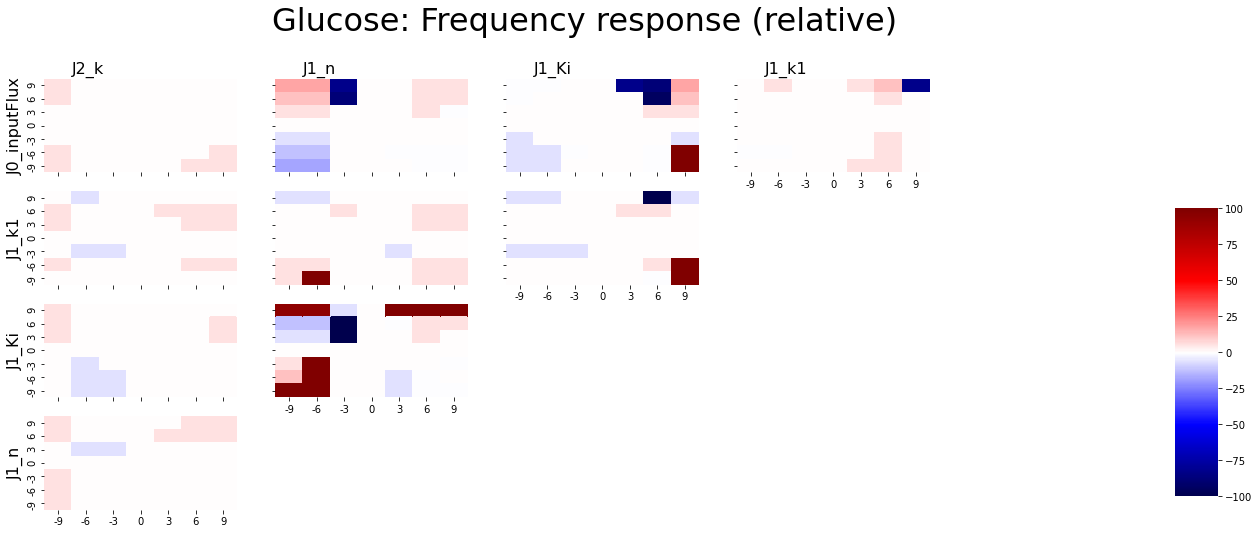

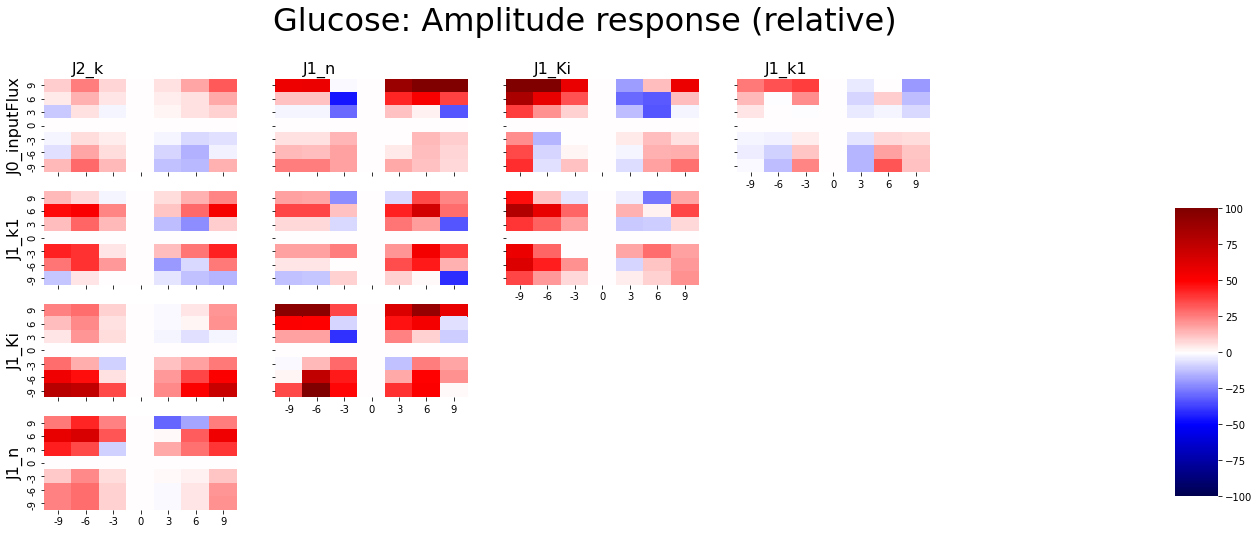

In [8]:
# Analysis for frequency with relative (precentage) responses
percents = 3*(np.array(range(7)) - 3)
molecule = "Glucose"
for isFrequency in [True, False]:
    util_doe2.runStudyTFC(molecule, wm.WOLF_PRMS[0:5], percents, isRelative=True, isFrequency=isFrequency,
                func=runExperimentsTwoParametersInteractionResponse)    

The OFT model works fairly well for frequency response with a few cases in which it overestimates interactions (presence of very negative $\gamma$ as indicated by dark blue) and a few caes of underestimates (deep red).

For amplitude, OFT consistently uderestimates interactions as see by the prevalence of red to dark red.

# Additional analyses

Discuss addiional analyses that should be done and explain why you would do them.

1. Study all floating species. This is essential because parameters may impact reactions in different ways.
1. Study all parameters that show significant effects in the OFT (one factor) studies. 
Using this criteria, we would not study J4_kk and J4_ka.
1. Where there are large changes in the response values between adjacent cells, using a finer grain differentiation in the levels of parameter values.